In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [3]:
import tensorflow as tf; tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **README**
* This is an implementation of a published work by **Dr. Francis Jesmar P. Montalbo**. 
* The paper is titled as **"Diagnosing Gastrointestinal Diseases from Endoscopy Images through a Multi-Fused CNN with Auxiliary Layers, Alpha Dropouts, and a Fusion Residual Block"**
* Please consider citing the paper if you find this helpful. It is highly appreciated and it helps.
* Please note that the credits for the datasets belong to their respective authors and that they must be cited accordingly. 

# MODEL CITATION
F. J. P. Montalbo, "Diagnosing Gastrointestinal Diseases from Endoscopy Images through a Multi-Fused CNN with Auxiliary Layers, Alpha Dropouts, and a Fusion Residual Block," *Biomedical Signal Processing and Control (BSPC)*, vol. 76, July, 2022, doi: 10.1016/j.bspc.2022.103683

Paper link: https://www.sciencedirect.com/science/article/pii/S1746809422002051

# DATASET CITATIONS

## KVASIR Dataset
K. Pogorelov et al., "KVASIR", Proceedings of the 8th ACM on Multimedia Systems Conference, 2017. DOI: <a href="https://dl.acm.org/doi/abs/10.1145/3083187.3083212"> 10.1145/3083187.3083212</a>.

## ETIS-Larib-Polyp DB Dataset
J. Silva, A. Histace, O. Romain, X. Dray and B. Granado, "Toward embedded detection of polyps in WCE images for early diagnosis of colorectal cancer", International Journal of Computer Assisted Radiology and Surgery, vol. 9, no. 2, pp. 283-293, 2013. DOI:<a href="https://link.springer.com/article/10.1007/s11548-013-0926-3/">10.1007/s11548-013-0926-3</a>.

# CONTACT
For further assitance or queries, you may contact the author via https://francismontalbo.github.io/

# ORIGINAL CODES
The original codes with GRAD-CAM visualizations are avaialable via github --> https://github.com/francismontalbo/mfurecnn

# GRAPHICAL ABSTRACT

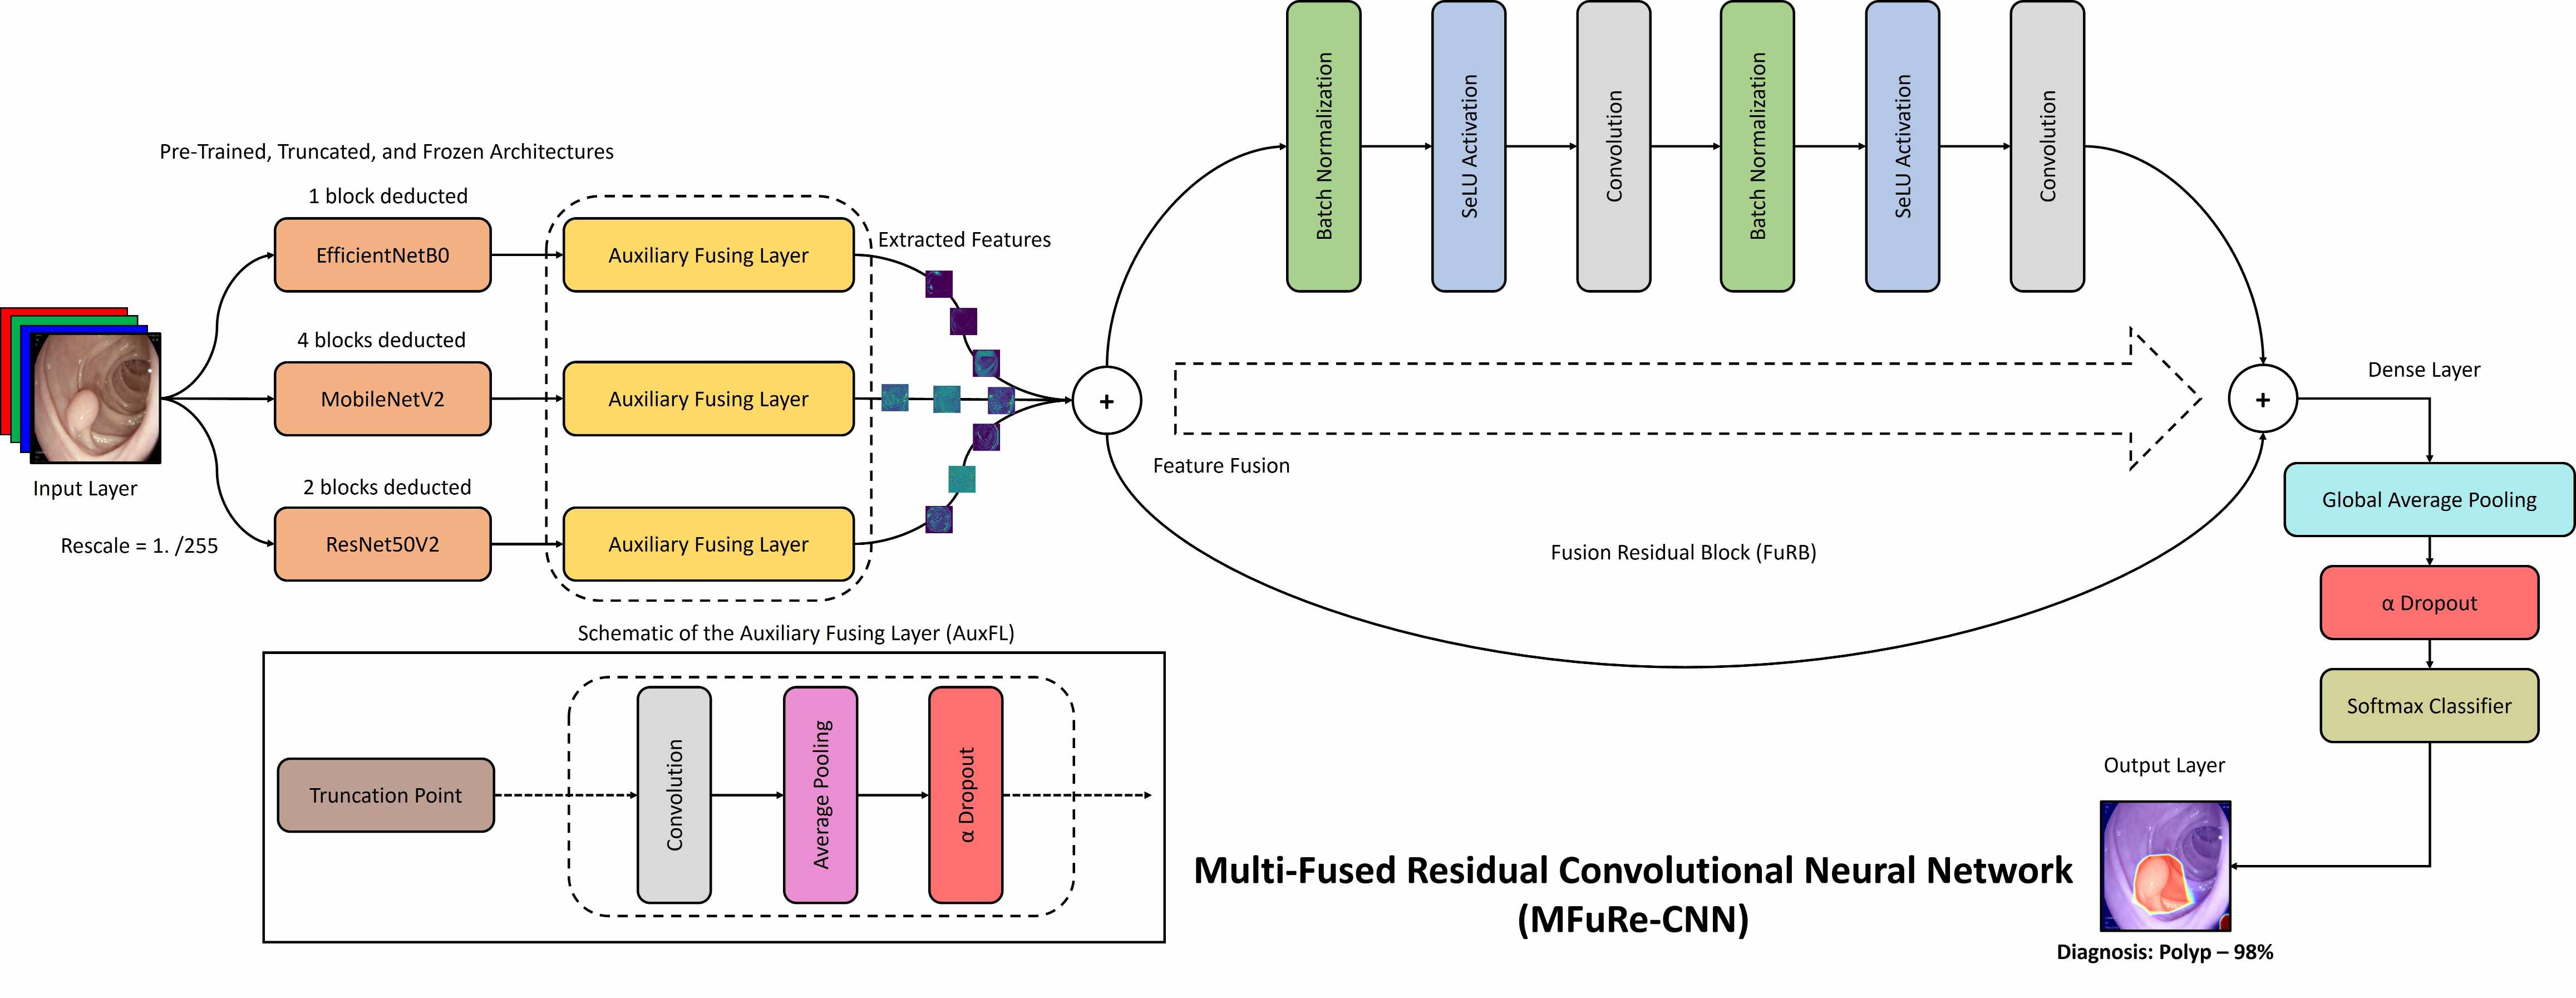

# LOAD DEPENDENCIES

In [6]:
#LOAD DEPENDENCIES
import os
import cv2
import time
import pickle
import logging
import itertools
import scikitplot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects



from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import applications
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.utils.layer_utils import count_params
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, classification_report, confusion_matrix, roc_curve, auc

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import AveragePooling2D, AlphaDropout, Activation, Add, BatchNormalization, Concatenate, Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

#Models 
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as trainable_model_a
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as trainable_model_b
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 as trainable_model_c

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("Packages successfully imported!")

Packages successfully imported!


# SET CONSTANTS

In [7]:
#Set constants 
#NOTE: These can be tuned if needed.
batch_size = 8
epochs = 25
optimizer = Adam(learning_rate=0.00001)
architecture = 'MFuReCNN_alpha_do'

In [8]:
#Set model identifiers
DCNN_A = 'DCNN_A' #EfficientNetB0
DCNN_B = 'DCNN_B' #MobileNetV2
DCNN_C = 'DCNN_C' #ResNet50V2

# CUSTOM FUNCTIONS

In [9]:
#Custom save function
def save_h(file, history):
    with open(file + '/' + architecture + '/' + architecture + '.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)
    print("history saved")

# DATASET PREPARATION

In [10]:
#LOAD THE DATA
main_dir = 'input/'

#Data split
train_data_dir = main_dir + "TRAIN/"
validation_data_dir = main_dir + "VAL/"
test_data_dir = main_dir + "TEST/"

#Set image shapes
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)

#Prompt
print("Data folders found!")
print("The Input size is set to ", model_input) 

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [11]:
#DATA GENERATORS
#Augment Training Data
class_names = ['0_normal', 
                '1_ulcerative_colitis', 
                '2_polyps', 
                '3_esophagitis']

train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=45,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   fill_mode='constant',
                                   brightness_range=[0.1, 1.0])
#DO NOT AUGMENT VALIDATION DATA!
val_datagen = ImageDataGenerator(rescale = 1. / 255)

#DO NOT AUGMENT TEST DATA!
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        classes=class_names)

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=class_names)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=class_names)

#CHECK  THE NUMBER OF SAMPLES BEFORE PROCEEDING!
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print("Train samples:", nb_train_samples)
print("Validation samples:", nb_validation_samples)
print("Test samples:", nb_test_samples)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")
    
if nb_test_samples == 0:
    print("NO DATA TEST FOUND! Please check your test data path and folders!")
    print("Check the data folders first!")
else:
    print("Test samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices
test_generator.class_indices

#true labels
Y_test=validation_generator.classes
test_labels = test_generator.classes

#Set number of classes automatically
num_classes= len(train_generator.class_indices)

print('Model set to train', num_classes, 'classes')

#Set prompt
if nb_train_samples and nb_validation_samples and nb_test_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Train samples: 3200
Validation samples: 2000
Test samples: 800
Train samples found!
Validation samples found!
Test samples found!
Model set to train 4 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


# PREPARE MODELS

In [12]:
# Model A
#EfficientNetB0
builder_a = DCNN_A + '_builder'

#TRANSFER LEARNING
def builder_a(model_input):
    builder_a = trainable_model_a(weights='imagenet', 
                                    include_top=False, 
                                    input_tensor = model_input)

#PARTIAL LAYER FREEZING
    for layer in builder_a.layers:
        layer.trainable = False
        
    for layer in builder_a.layers:
        layer._name = layer.name + '_' + DCNN_A
        
    for BatchNormalization in builder_a.layers:
        BatchNormalization.trainable = False
    
#LAYER COMPRESSION
    x = builder_a.layers[-17].output #Equivalent to one (1) CORE block deduction.
    
#AUXILIARY FUSING LAYER (AuxFL)
    x = Conv2D(192, 1, padding='valid', activation='selu', kernel_initializer='lecun_normal')(x)
    x = AveragePooling2D(1, 1)(x)
    x = AlphaDropout(0.2)(x)

    dcnn_a = Model(inputs=builder_a.input, outputs=x, name=DCNN_A)
    return dcnn_a

#INITIALIZE THE MODEL
dcnn_a = builder_a(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
dcnn_a.summary()
print("successfully built!")

16705208/16705208 [==============================] - 22s 1us/step
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "DCNN_A"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_DCNN_A (Rescaling)   (None, 224, 224, 3)  0           ['input_1_DCNN_A[0][0]']         
                                                                                                  
 normalization_DCNN_A (Normaliz  (None, 224, 224, 3)  7          ['rescaling_DCNN_A[0][0]']       
 ation)                                                                           

 block2a_se_reshape_DCNN_A (Res  (None, 1, 1, 96)    0           ['block2a_se_squeeze_DCNN_A[0][0]
 hape)                                                           ']                               
                                                                                                  
 block2a_se_reduce_DCNN_A (Conv  (None, 1, 1, 4)     388         ['block2a_se_reshape_DCNN_A[0][0]
 2D)                                                             ']                               
                                                                                                  
 block2a_se_expand_DCNN_A (Conv  (None, 1, 1, 96)    480         ['block2a_se_reduce_DCNN_A[0][0]'
 2D)                                                             ]                                
                                                                                                  
 block2a_se_excite_DCNN_A (Mult  (None, 56, 56, 96)  0           ['block2a_activation_DCNN_A[0][0]
 iply)    

 block3a_bn_DCNN_A (BatchNormal  (None, 28, 28, 144)  576        ['block3a_dwconv_DCNN_A[0][0]']  
 ization)                                                                                         
                                                                                                  
 block3a_activation_DCNN_A (Act  (None, 28, 28, 144)  0          ['block3a_bn_DCNN_A[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_se_squeeze_DCNN_A (Glo  (None, 144)         0           ['block3a_activation_DCNN_A[0][0]
 balAveragePooling2D)                                            ']                               
                                                                                                  
 block3a_se_reshape_DCNN_A (Res  (None, 1, 1, 144)   0           ['block3a_se_squeeze_DCNN_A[0][0]
 hape)    

 block4a_expand_activation_DCNN  (None, 28, 28, 240)  0          ['block4a_expand_bn_DCNN_A[0][0]'
 _A (Activation)                                                 ]                                
                                                                                                  
 block4a_dwconv_pad_DCNN_A (Zer  (None, 29, 29, 240)  0          ['block4a_expand_activation_DCNN_
 oPadding2D)                                                     A[0][0]']                        
                                                                                                  
 block4a_dwconv_DCNN_A (Depthwi  (None, 14, 14, 240)  2160       ['block4a_dwconv_pad_DCNN_A[0][0]
 seConv2D)                                                       ']                               
                                                                                                  
 block4a_bn_DCNN_A (BatchNormal  (None, 14, 14, 240)  960        ['block4a_dwconv_DCNN_A[0][0]']  
 ization) 

                                                                  'block4a_project_bn_DCNN_A[0][0]
                                                                 ']                               
                                                                                                  
 block4c_expand_conv_DCNN_A (Co  (None, 14, 14, 480)  38400      ['block4b_add_DCNN_A[0][0]']     
 nv2D)                                                                                            
                                                                                                  
 block4c_expand_bn_DCNN_A (Batc  (None, 14, 14, 480)  1920       ['block4c_expand_conv_DCNN_A[0][0
 hNormalization)                                                 ]']                              
                                                                                                  
 block4c_expand_activation_DCNN  (None, 14, 14, 480)  0          ['block4c_expand_bn_DCNN_A[0][0]'
 _A (Activ

                                                                 ]                                
                                                                                                  
 block5a_project_conv_DCNN_A (C  (None, 14, 14, 112)  53760      ['block5a_se_excite_DCNN_A[0][0]'
 onv2D)                                                          ]                                
                                                                                                  
 block5a_project_bn_DCNN_A (Bat  (None, 14, 14, 112)  448        ['block5a_project_conv_DCNN_A[0][
 chNormalization)                                                0]']                             
                                                                                                  
 block5b_expand_conv_DCNN_A (Co  (None, 14, 14, 672)  75264      ['block5a_project_bn_DCNN_A[0][0]
 nv2D)                                                           ']                               
          

 block5c_se_expand_DCNN_A (Conv  (None, 1, 1, 672)   19488       ['block5c_se_reduce_DCNN_A[0][0]'
 2D)                                                             ]                                
                                                                                                  
 block5c_se_excite_DCNN_A (Mult  (None, 14, 14, 672)  0          ['block5c_activation_DCNN_A[0][0]
 iply)                                                           ',                               
                                                                  'block5c_se_expand_DCNN_A[0][0]'
                                                                 ]                                
                                                                                                  
 block5c_project_conv_DCNN_A (C  (None, 14, 14, 112)  75264      ['block5c_se_excite_DCNN_A[0][0]'
 onv2D)                                                          ]                                
          

 balAveragePooling2D)                                            ']                               
                                                                                                  
 block6b_se_reshape_DCNN_A (Res  (None, 1, 1, 1152)  0           ['block6b_se_squeeze_DCNN_A[0][0]
 hape)                                                           ']                               
                                                                                                  
 block6b_se_reduce_DCNN_A (Conv  (None, 1, 1, 48)    55344       ['block6b_se_reshape_DCNN_A[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6b_se_expand_DCNN_A (Conv  (None, 1, 1, 1152)  56448       ['block6b_se_reduce_DCNN_A[0][0]'
 2D)                                                             ]                                
          

 _A (Activation)                                                 ]                                
                                                                                                  
 block6d_dwconv_DCNN_A (Depthwi  (None, 7, 7, 1152)  28800       ['block6d_expand_activation_DCNN_
 seConv2D)                                                       A[0][0]']                        
                                                                                                  
 block6d_bn_DCNN_A (BatchNormal  (None, 7, 7, 1152)  4608        ['block6d_dwconv_DCNN_A[0][0]']  
 ization)                                                                                         
                                                                                                  
 block6d_activation_DCNN_A (Act  (None, 7, 7, 1152)  0           ['block6d_bn_DCNN_A[0][0]']      
 ivation)                                                                                         
          

In [13]:
# Model B
#MobileNetV2
builder_b = DCNN_B + '_builder'

#TRANSFER LEARNING
def builder_b(model_input):
    builder_b = trainable_model_b(weights='imagenet', 
                                    include_top=False, 
                                    input_tensor = model_input)

#PARTIAL LAYER FREEZING
    for layer in builder_b.layers:
        layer.trainable = False
        
    for layer in builder_b.layers:
        layer._name = layer.name + '_' + DCNN_B
        
    for BatchNormalization in builder_b.layers:
        BatchNormalization.trainable = False
    
#LAYER COMPRESSION
    x = builder_b.layers[-39].output #Equivalent to four (4) CORE block deduction.
    
#AUXILIARY FUSING LAYER (AuxFL)
    x = Conv2D(192, 8, padding='valid', activation='selu', kernel_initializer='lecun_normal')(x)
    x = AveragePooling2D(1, 1)(x)
    x = AlphaDropout(0.2)(x)

    dcnn_b = Model(inputs=builder_b.input, outputs=x, name=DCNN_B)
    return dcnn_b

#INITIALIZE THE MODEL
dcnn_b = builder_b(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
dcnn_b.summary()
print(" successfully built!")

9406464/9406464 [==============================] - 9s 1us/step
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "DCNN_B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A_DCNN_B (InputLa  [(None, 224, 224, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 Conv1_DCNN_B (Conv2D)          (None, 112, 112, 32  864         ['input_1_DCNN_A_DCNN_B[0][0]']  
                                )                                                                 
                                                                                                  
 bn_Conv1_DCNN_B (BatchNormaliz  (None, 112, 112, 32  128        ['Conv1_DCNN_B[0][0]

                                                                                                  
 block_2_add_DCNN_B (Add)       (None, 56, 56, 24)   0           ['block_1_project_BN_DCNN_B[0][0]
                                                                 ',                               
                                                                  'block_2_project_BN_DCNN_B[0][0]
                                                                 ']                               
                                                                                                  
 block_3_expand_DCNN_B (Conv2D)  (None, 56, 56, 144)  3456       ['block_2_add_DCNN_B[0][0]']     
                                                                                                  
 block_3_expand_BN_DCNN_B (Batc  (None, 56, 56, 144)  576        ['block_3_expand_DCNN_B[0][0]']  
 hNormalization)                                                                                  
          

                                                                                                  
 block_5_add_DCNN_B (Add)       (None, 28, 28, 32)   0           ['block_4_add_DCNN_B[0][0]',     
                                                                  'block_5_project_BN_DCNN_B[0][0]
                                                                 ']                               
                                                                                                  
 block_6_expand_DCNN_B (Conv2D)  (None, 28, 28, 192)  6144       ['block_5_add_DCNN_B[0][0]']     
                                                                                                  
 block_6_expand_BN_DCNN_B (Batc  (None, 28, 28, 192)  768        ['block_6_expand_DCNN_B[0][0]']  
 hNormalization)                                                                                  
                                                                                                  
 block_6_e

 block_8_add_DCNN_B (Add)       (None, 14, 14, 64)   0           ['block_7_add_DCNN_B[0][0]',     
                                                                  'block_8_project_BN_DCNN_B[0][0]
                                                                 ']                               
                                                                                                  
 block_9_expand_DCNN_B (Conv2D)  (None, 14, 14, 384)  24576      ['block_8_add_DCNN_B[0][0]']     
                                                                                                  
 block_9_expand_BN_DCNN_B (Batc  (None, 14, 14, 384)  1536       ['block_9_expand_DCNN_B[0][0]']  
 hNormalization)                                                                                  
                                                                                                  
 block_9_expand_relu_DCNN_B (Re  (None, 14, 14, 384)  0          ['block_9_expand_BN_DCNN_B[0][0]'
 LU)      

                                                                                                  
 block_12_expand_DCNN_B (Conv2D  (None, 14, 14, 576)  55296      ['block_11_add_DCNN_B[0][0]']    
 )                                                                                                
                                                                                                  
 block_12_expand_BN_DCNN_B (Bat  (None, 14, 14, 576)  2304       ['block_12_expand_DCNN_B[0][0]'] 
 chNormalization)                                                                                 
                                                                                                  
 block_12_expand_relu_DCNN_B (R  (None, 14, 14, 576)  0          ['block_12_expand_BN_DCNN_B[0][0]
 eLU)                                                            ']                               
                                                                                                  
 block_12_

In [14]:
# Model C
#ResNet50V2
builder_c = DCNN_C + '_builder'

#TRANSFER LEARNING
def builder_c(model_input):
    builder_c = trainable_model_c(weights='imagenet', 
                                    include_top=False, 
                                    input_tensor = model_input)

#PARTIAL LAYER FREEZING
    for layer in builder_c.layers:
        layer.trainable = False
        
    for layer in builder_c.layers:
        layer._name = layer.name + '_' + DCNN_C
        
    for BatchNormalization in builder_c.layers:
        BatchNormalization.trainable = False
    
#LAYER COMPRESSION
    x = builder_c.layers[-117].output #Equivalent to two (2) CORE block deduction.
    
 #AUXILIARY FUSING LAYER (AuxFL)   
    x = Conv2D(192, 6, padding='valid', activation='selu', kernel_initializer='lecun_normal')(x)
    x = AveragePooling2D(3, 3)(x)
    x = AlphaDropout(0.2)(x)

    dcnn_c = Model(inputs=builder_c.input, outputs=x, name=DCNN_C)
    return dcnn_c

#INITIALIZE THE MODEL
dcnn_c = builder_c(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
dcnn_c.summary()
print("successfully built!")

94668760/94668760 [==============================] - 129s 1us/step
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "DCNN_C"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A_DCNN_B_DCNN_C (  [(None, 224, 224, 3  0          []                               
 InputLayer)                    )]                                                                
                                                                                                  
 conv1_pad_DCNN_C (ZeroPadding2  (None, 230, 230, 3)  0          ['input_1_DCNN_A_DCNN_B_DCNN_C[0]
 D)                                                              [0]']                            
                                                                                                  
 conv1_conv_DCNN_C (Conv2D)     (None, 112, 112, 64  9472        ['conv1_pad_DCNN

 tivation)                                                       ]                                
                                                                                                  
 conv2_block2_3_conv_DCNN_C (Co  (None, 56, 56, 256)  16640      ['conv2_block2_2_relu_DCNN_C[0][0
 nv2D)                                                           ]']                              
                                                                                                  
 conv2_block2_out_DCNN_C (Add)  (None, 56, 56, 256)  0           ['conv2_block1_out_DCNN_C[0][0]',
                                                                  'conv2_block2_3_conv_DCNN_C[0][0
                                                                 ]']                              
                                                                                                  
 conv2_block3_preact_bn_DCNN_C   (None, 56, 56, 256)  1024       ['conv2_block2_out_DCNN_C[0][0]']
 (BatchNor

                                                                                                  
 conv3_block2_preact_bn_DCNN_C   (None, 28, 28, 512)  2048       ['conv3_block1_out_DCNN_C[0][0]']
 (BatchNormalization)                                                                             
                                                                                                  
 conv3_block2_preact_relu_DCNN_  (None, 28, 28, 512)  0          ['conv3_block2_preact_bn_DCNN_C[0
 C (Activation)                                                  ][0]']                           
                                                                                                  
 conv3_block2_1_conv_DCNN_C (Co  (None, 28, 28, 128)  65536      ['conv3_block2_preact_relu_DCNN_C
 nv2D)                                                           [0][0]']                         
                                                                                                  
 conv3_blo

# PREPARE FUSION

In [15]:
#RE-INITIALIZE FOR FUSION
dcnn_a = builder_a(model_input)
dcnn_b = builder_b(model_input)
dcnn_c = builder_c(model_input)

print("Accomplished Pre-training and ready for fusion")

Accomplished Pre-training and ready for fusion


In [16]:
#FUSE THE MODELS INTO A SINGLE PIPELINE
models = [dcnn_a, 
          dcnn_b,
          dcnn_c]

print("Fusion success!")
print("Ready to connect with its ending layers!")

Fusion success!
Ready to connect with its ending layers!


In [17]:
#Build the Fusion Residual Block (FuRB)
def mfurecnn_builder(models, model_input):
    outputs = [m.output for m in models]
    
#INITIAL FUSION LAYER
    y = Add(name='InitialFusionLayer')(outputs)
    
#FuRB LAYER
    y_bn1 = BatchNormalization()(y)
    y_selu1 = tf.keras.activations.selu(y_bn1)
    y_conv1 = Conv2D(192, 1, kernel_initializer='lecun_normal')(y_selu1)
    y_bn2 = BatchNormalization()(y_conv1)
    y_selu2 = tf.keras.activations.selu(y_bn2)
    y_conv2 = Conv2D(192, 1, kernel_initializer='lecun_normal')(y_selu2)
    
    y_merge = Add(name='FuRB')([y, y_conv2])
    
#FINE-TUNING LAYER
    y = GlobalAveragePooling2D()(y_merge)
    y = AlphaDropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax', name='Softmax_Classifier' + architecture)(y)
    model = Model(model_input, prediction, name=architecture)
    return model

#Istantitate the model and report the summary
mfurecnn = mfurecnn_builder(models, model_input)
mfurecnn._name = "MFuReCNN"
model_name = mfurecnn._name

print()
print()
print("PLEASE CHECK THE MODEL UP TO THE END")
print()
print()
print()

mfurecnn.summary()
print("The", model_name, "is now complete and ready for compilation and training!")



PLEASE CHECK THE MODEL UP TO THE END



Model: "MFuReCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A_DCNN_B_DCNN_C_D  [(None, 224, 224, 3  0          []                               
 CNN_A_DCNN_B_DCNN_C (InputLaye  )]                                                               
 r)                                                                                               
                                                                                                  
 rescaling_2_DCNN_A (Rescaling)  (None, 224, 224, 3)  0          ['input_1_DCNN_A_DCNN_B_DCNN_C_DC
                                                                 NN_A_DCNN_B_DCNN_C[0][0]']       
                                                                                                  
 normalization_1_DCNN_A (Normal  (None, 224, 224,

 block2a_se_reshape_DCNN_A (Res  (None, 1, 1, 96)    0           ['block2a_se_squeeze_DCNN_A[0][0]
 hape)                                                           ']                               
                                                                                                  
 block2a_se_reduce_DCNN_A (Conv  (None, 1, 1, 4)     388         ['block2a_se_reshape_DCNN_A[0][0]
 2D)                                                             ']                               
                                                                                                  
 block2a_se_expand_DCNN_A (Conv  (None, 1, 1, 96)    480         ['block2a_se_reduce_DCNN_A[0][0]'
 2D)                                                             ]                                
                                                                                                  
 block2a_se_excite_DCNN_A (Mult  (None, 56, 56, 96)  0           ['block2a_activation_DCNN_A[0][0]
 iply)    

 block3a_bn_DCNN_A (BatchNormal  (None, 28, 28, 144)  576        ['block3a_dwconv_DCNN_A[0][0]']  
 ization)                                                                                         
                                                                                                  
 block3a_activation_DCNN_A (Act  (None, 28, 28, 144)  0          ['block3a_bn_DCNN_A[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_se_squeeze_DCNN_A (Glo  (None, 144)         0           ['block3a_activation_DCNN_A[0][0]
 balAveragePooling2D)                                            ']                               
                                                                                                  
 block3a_se_reshape_DCNN_A (Res  (None, 1, 1, 144)   0           ['block3a_se_squeeze_DCNN_A[0][0]
 hape)    

 block4a_expand_activation_DCNN  (None, 28, 28, 240)  0          ['block4a_expand_bn_DCNN_A[0][0]'
 _A (Activation)                                                 ]                                
                                                                                                  
 block4a_dwconv_pad_DCNN_A (Zer  (None, 29, 29, 240)  0          ['block4a_expand_activation_DCNN_
 oPadding2D)                                                     A[0][0]']                        
                                                                                                  
 block4a_dwconv_DCNN_A (Depthwi  (None, 14, 14, 240)  2160       ['block4a_dwconv_pad_DCNN_A[0][0]
 seConv2D)                                                       ']                               
                                                                                                  
 block4a_bn_DCNN_A (BatchNormal  (None, 14, 14, 240)  960        ['block4a_dwconv_DCNN_A[0][0]']  
 ization) 

                                                                  'block4a_project_bn_DCNN_A[0][0]
                                                                 ']                               
                                                                                                  
 block4c_expand_conv_DCNN_A (Co  (None, 14, 14, 480)  38400      ['block4b_add_DCNN_A[0][0]']     
 nv2D)                                                                                            
                                                                                                  
 block4c_expand_bn_DCNN_A (Batc  (None, 14, 14, 480)  1920       ['block4c_expand_conv_DCNN_A[0][0
 hNormalization)                                                 ]']                              
                                                                                                  
 block4c_expand_activation_DCNN  (None, 14, 14, 480)  0          ['block4c_expand_bn_DCNN_A[0][0]'
 _A (Activ

 block4c_add_DCNN_A (Add)       (None, 14, 14, 80)   0           ['block4c_drop_DCNN_A[0][0]',    
                                                                  'block4b_add_DCNN_A[0][0]']     
                                                                                                  
 block_1_depthwise_DCNN_B (Dept  (None, 56, 56, 96)  864         ['block_1_pad_DCNN_B[0][0]']     
 hwiseConv2D)                                                                                     
                                                                                                  
 block5a_expand_conv_DCNN_A (Co  (None, 14, 14, 480)  38400      ['block4c_add_DCNN_A[0][0]']     
 nv2D)                                                                                            
                                                                                                  
 block_1_depthwise_BN_DCNN_B (B  (None, 56, 56, 96)  384         ['block_1_depthwise_DCNN_B[0][0]'
 atchNorma

 block_2_add_DCNN_B (Add)       (None, 56, 56, 24)   0           ['block_1_project_BN_DCNN_B[0][0]
                                                                 ',                               
                                                                  'block_2_project_BN_DCNN_B[0][0]
                                                                 ']                               
                                                                                                  
 block5b_expand_conv_DCNN_A (Co  (None, 14, 14, 672)  75264      ['block5a_project_bn_DCNN_A[0][0]
 nv2D)                                                           ']                               
                                                                                                  
 block_3_expand_DCNN_B (Conv2D)  (None, 56, 56, 144)  3456       ['block_2_add_DCNN_B[0][0]']     
                                                                                                  
 block5b_e

                                                                                                  
 block5b_drop_DCNN_A (Dropout)  (None, 14, 14, 112)  0           ['block5b_project_bn_DCNN_A[0][0]
                                                                 ']                               
                                                                                                  
 block_4_depthwise_BN_DCNN_B (B  (None, 28, 28, 192)  768        ['block_4_depthwise_DCNN_B[0][0]'
 atchNormalization)                                              ]                                
                                                                                                  
 block5b_add_DCNN_A (Add)       (None, 14, 14, 112)  0           ['block5b_drop_DCNN_A[0][0]',    
                                                                  'block5a_project_bn_DCNN_A[0][0]
                                                                 ']                               
          

                                                                                                  
 block5c_se_expand_DCNN_A (Conv  (None, 1, 1, 672)   19488       ['block5c_se_reduce_DCNN_A[0][0]'
 2D)                                                             ]                                
                                                                                                  
 block_5_project_DCNN_B (Conv2D  (None, 28, 28, 32)  6144        ['block_5_depthwise_relu_DCNN_B[0
 )                                                               ][0]']                           
                                                                                                  
 conv2_block1_preact_relu_DCNN_  (None, 56, 56, 64)  0           ['conv2_block1_preact_bn_DCNN_C[0
 C (Activation)                                                  ][0]']                           
                                                                                                  
 block5c_s

                                                                                                  
 conv2_block1_3_conv_DCNN_C (Co  (None, 56, 56, 256)  16640      ['conv2_block1_2_relu_DCNN_C[0][0
 nv2D)                                                           ]']                              
                                                                                                  
 block6a_dwconv_pad_DCNN_A (Zer  (None, 17, 17, 672)  0          ['block6a_expand_activation_DCNN_
 oPadding2D)                                                     A[0][0]']                        
                                                                                                  
 block_6_depthwise_relu_DCNN_B   (None, 14, 14, 192)  0          ['block_6_depthwise_BN_DCNN_B[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 conv2_blo

 block_7_depthwise_relu_DCNN_B   (None, 14, 14, 384)  0          ['block_7_depthwise_BN_DCNN_B[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 conv2_block2_2_bn_DCNN_C (Batc  (None, 56, 56, 64)  256         ['conv2_block2_2_conv_DCNN_C[0][0
 hNormalization)                                                 ]']                              
                                                                                                  
 block6a_project_conv_DCNN_A (C  (None, 7, 7, 192)   129024      ['block6a_se_excite_DCNN_A[0][0]'
 onv2D)                                                          ]                                
                                                                                                  
 block_7_project_DCNN_B (Conv2D  (None, 14, 14, 64)  24576       ['block_7_depthwise_relu_DCNN_B[0
 )        

 block_8_depthwise_relu_DCNN_B   (None, 14, 14, 384)  0          ['block_8_depthwise_BN_DCNN_B[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 conv2_block3_2_pad_DCNN_C (Zer  (None, 58, 58, 64)  0           ['conv2_block3_1_relu_DCNN_C[0][0
 oPadding2D)                                                     ]']                              
                                                                                                  
 block6b_se_reshape_DCNN_A (Res  (None, 1, 1, 1152)  0           ['block6b_se_squeeze_DCNN_A[0][0]
 hape)                                                           ']                               
                                                                                                  
 block_8_project_DCNN_B (Conv2D  (None, 14, 14, 64)  24576       ['block_8_depthwise_relu_DCNN_B[0
 )        

 nv2D)                                                           [0][0]']                         
                                                                                                  
 block6c_expand_conv_DCNN_A (Co  (None, 7, 7, 1152)  221184      ['block6b_add_DCNN_A[0][0]']     
 nv2D)                                                                                            
                                                                                                  
 block_9_depthwise_relu_DCNN_B   (None, 14, 14, 384)  0          ['block_9_depthwise_BN_DCNN_B[0][
 (ReLU)                                                          0]']                             
                                                                                                  
 conv3_block1_1_bn_DCNN_C (Batc  (None, 28, 28, 128)  512        ['conv3_block1_1_conv_DCNN_C[0][0
 hNormalization)                                                 ]']                              
          

 block_10_depthwise_BN_DCNN_B (  (None, 14, 14, 384)  1536       ['block_10_depthwise_DCNN_B[0][0]
 BatchNormalization)                                             ']                               
                                                                                                  
 conv3_block2_preact_bn_DCNN_C   (None, 28, 28, 512)  2048       ['conv3_block1_out_DCNN_C[0][0]']
 (BatchNormalization)                                                                             
                                                                                                  
 block6c_se_expand_DCNN_A (Conv  (None, 1, 1, 1152)  56448       ['block6c_se_reduce_DCNN_A[0][0]'
 2D)                                                             ]                                
                                                                                                  
 block_10_depthwise_relu_DCNN_B  (None, 14, 14, 384)  0          ['block_10_depthwise_BN_DCNN_B[0]
  (ReLU)  

 block_11_depthwise_relu_DCNN_B  (None, 14, 14, 576)  0          ['block_11_depthwise_BN_DCNN_B[0]
  (ReLU)                                                         [0]']                            
                                                                                                  
 conv3_block2_3_conv_DCNN_C (Co  (None, 28, 28, 512)  66048      ['conv3_block2_2_relu_DCNN_C[0][0
 nv2D)                                                           ]']                              
                                                                                                  
 block6d_dwconv_DCNN_A (Depthwi  (None, 7, 7, 1152)  28800       ['block6d_expand_activation_DCNN_
 seConv2D)                                                       A[0][0]']                        
                                                                                                  
 block_11_project_DCNN_B (Conv2  (None, 14, 14, 96)  55296       ['block_11_depthwise_relu_DCNN_B[
 D)       

 block6d_project_conv_DCNN_A (C  (None, 7, 7, 192)   221184      ['block6d_se_excite_DCNN_A[0][0]'
 onv2D)                                                          ]                                
                                                                                                  
 block_12_depthwise_relu_DCNN_B  (None, 14, 14, 576)  0          ['block_12_depthwise_BN_DCNN_B[0]
  (ReLU)                                                         [0]']                            
                                                                                                  
 conv3_block3_2_bn_DCNN_C (Batc  (None, 28, 28, 128)  512        ['conv3_block3_2_conv_DCNN_C[0][0
 hNormalization)                                                 ]']                              
                                                                                                  
 block6d_project_bn_DCNN_A (Bat  (None, 7, 7, 192)   768         ['block6d_project_conv_DCNN_A[0][
 chNormali

 alpha_dropout_6 (AlphaDropout)  (None, 192)         0           ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 Softmax_ClassifierMFuReCNN_alp  (None, 4)           772         ['alpha_dropout_6[0][0]']        
 ha_do (Dense)                                                                                    
                                                                                                  
Total params: 9,474,935
Trainable params: 4,831,684
Non-trainable params: 4,643,251
__________________________________________________________________________________________________
The MFuReCNN is now complete and ready for compilation and training!


In [18]:
#Check the layer, the final layer should be FuRB!
last_conv_layer_name = mfurecnn.layers[-4].name

if last_conv_layer_name == 'FuRB':
    print("CORRECT LAYER SELECTED:", last_conv_layer_name)
else:
    print("INCORRECT LAYER SELECTED:", last_conv_layer_name)
    print("Please Reselect")

CORRECT LAYER SELECTED: FuRB


# SAVE POINT

In [19]:
#save json file
model_dir = 'model/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print('Model directory', model_dir, 'successfully created')
else:
    print('Model directory already exist, no new directory made.')

print()
print('-'*50)
print('Model directory is available for saving the', model_name, 'model!')
print('-'*50)

Model directory already exist, no new directory made.

--------------------------------------------------
Model directory is available for saving the MFuReCNN model!
--------------------------------------------------


# COMPILE MODEL

In [20]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
mfurecnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max')

callbacks = [reduce_lr]

print('-'*50)
print('Successfully compiled the', model_name, 'model!')
print('You may now proceed in training the', model_name, 'model!')
print('-'*50)

--------------------------------------------------
Successfully compiled the MFuReCNN model!
You may now proceed in training the MFuReCNN model!
--------------------------------------------------


# TRAIN THE Multi-Fused Residual CNN MODEL (MFuRe-CNN)

In [ ]:
# MODEL TRAINING

#Set training time
start_time = time.time()
print('*'*50)
print("Training", model_name)
print('*'*50)
print('-'*50)
print("Training time is being measured")
print('-'*50)
history = mfurecnn.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZATION DONE!")

**************************************************
Training MFuReCNN
**************************************************
--------------------------------------------------
Training time is being measured
--------------------------------------------------
Epoch 1/25
400/400 [==============================] - 79s 145ms/step - loss: 1.2087 - accuracy: 0.5447 - val_loss: 0.5392 - val_accuracy: 0.8245 - lr: 1.0000e-05
Epoch 2/25
137/400 [=========>....................] - ETA: 29s - loss: 0.6576 - accuracy: 0.7454

# SAVE THE TRAINED MODEL

In [ ]:
#SAVE AFTER TRAINING COMPLETES
mfurecnn.save('model/' + architecture + '/' + architecture + '.h5')

# #SAVE THE HISTORY FOR EVALUATION
save_h('model/', history.history)

#Prompt
print("-"*50)
print()
print("The Model weights and history of the", model_name, "successfully trained and saved!")
print()
print("-"*50)

In [ ]:
#Re-load the trained model
model = load_model('model/' + architecture + '/' + architecture + '.h5')
print("The", model_name,  "is successfully loaded!")

# EVALUATION WITH VALIDATION DATASET

In [ ]:
#evaluate validation accuracy
y_pred = model.predict(validation_generator, 
                                 nb_validation_samples/batch_size, workers=1)

accuracy = accuracy_score(Y_test, y_pred.argmax(axis=-1))
print('The val accuracy of the ' + model._name + ' is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test, y_pred.argmax(axis=-1))
print('The val MSE of the ' + model._name + ' is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test, y_pred.argmax(axis=-1))  
print('The val MSLE of the ' + model._name +  ' is: ', msle)

In [ ]:
#Modify only as needed

#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'

#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

In [ ]:
#Convergence
plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = dpi, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)

plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history.history["accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_accuracy, 
         lw = line_width_train, 
         marker = marker_train_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, 
         label = train_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["val_accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_accuracy, 
         lw = line_width_val, 
         marker = marker_validation_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_loss, 
         lw = line_width_train, 
         marker = marker_train_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, label = train_loss_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["val_loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_loss, 
         lw = line_width_val, 
         marker = marker_validation_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_loss_label)

plt.xlabel("Epochs", fontfamily = x_label_font, fontsize = x_label_font_size, color ='black')
plt.ylabel("Accuracy/Loss", fontfamily = y_label_font, fontsize = y_label_font_size, color = 'black')

legend = plt.legend(loc = legend_location, 
                    ncol = legend_ncol, 
                    frameon = legend_has_frame, 
                    fontsize=legend_font_size, 
                    edgecolor=legend_edge_color, 
                    borderpad=legend_border_pad, 
                    labelspacing=legend_label_spacing)

frame = legend.get_frame()
legend.get_frame().set_linewidth(legend_line_width)
legend.get_frame().set_edgecolor(legend_edge_color)
plt.setp(legend.texts, family = legend_font)
plt.tight_layout()

In [ ]:
# Confusion Matrix (Normalized)
fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title=model._name + ' Val',
                          cmap=plt.cm.binary):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3'] #0-Normal, 1-Ulcer, 2-Polyps, 3-Esophagitis
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=dpi)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.show()

In [ ]:
#Re-updated plotting format for CURVES
plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

In [ ]:
#ROC validation
scikitplot.metrics.plot_roc(Y_test, y_pred)
plt.title(model._name + ' Val' + ' ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [ ]:
#P-R validation
scikitplot.metrics.plot_precision_recall(Y_test, y_pred)
plt.title(model._name + ' Val' + ' P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [ ]:
#Sanity check for validation
model.evaluate(validation_generator, return_dict=True)

# EVALUATION WITH TEST DATASET

In [ ]:
#Evaluate test accuracy
y_pred_test = model.predict(test_generator, 
                                 nb_test_samples/batch_size, workers=1)

accuracy_test = accuracy_score(test_labels, y_pred_test.argmax(axis=-1))
print('The test accuracy of the ' + model._name + ' is: ', accuracy_test)

#evaluate mean squared error
mse_test = mean_squared_error(test_labels, y_pred_test.argmax(axis=-1))
print('The test MSE of the ' + model._name + ' is: ', mse_test)

#evaluate mean squared log error
msle_test = mean_squared_log_error(test_labels, y_pred_test.argmax(axis=-1))  
print('The test MSLE of the ' + model._name +  ' is: ', msle_test)

In [ ]:
# Confusion Matrix (Normalized)
fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title=model._name + ' Test',
                          cmap=plt.cm.binary):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3'] #0-Normal, 1-Ulcer, 2-Polyps, 3-Esophagitis
print(classification_report(test_labels, y_pred_test.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(test_labels, y_pred_test.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=dpi)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.show()

In [ ]:
#Re-updated plotting format for CURVES
plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

In [ ]:
#ROC test
scikitplot.metrics.plot_roc(test_labels, y_pred_test)
plt.title(model._name + ' Test' + ' ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [ ]:
#P-R test
scikitplot.metrics.plot_precision_recall(test_labels, y_pred_test)
plt.title(model._name + ' Test' + ' P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [ ]:
#Sanity check for test
model.evaluate(test_generator, return_dict=True)

In [ ]:
#Cost-efficiency
def cost_compute():
    flops  = float("{0:.2f}".format(get_flops(Model(model.input, model.output), batch_size=1)/ 10 ** 9))
    params = float("{0:.2f}".format(model.count_params() / 10 ** 6))
    trainable_count = float("{0:.2f}".format(count_params(model.trainable_weights) / 10 ** 6))
    print("FLOPS:", flops, "GFLOPS")
    print("Params:", params, "M")

cost_compute()